In [32]:
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [33]:
dataset_train = datasets.MNIST('MNIST-data', train = True, download = True, transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = 256, shuffle = True)
dataset_test = datasets.MNIST('MNIST-data', train = False, download = True, transform = transforms.ToTensor())
val_loader = torch.utils.data.DataLoader(dataset_test, batch_size = 256, shuffle = True)

In [34]:
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    # in_features = largura*altura*canais -> 28*28 = 784
    self.dense0 = nn.Linear(in_features = 784, out_features = 32)
    self.activation0 = nn.ReLU()
    self.dense1 = nn.Linear(32, 784)
    self.activation1 = nn.Sigmoid()

  def forward(self, x):
    # view significa mudar a estrutura de dados (matrix -> vetor)
    # -1 significa um numero indeterminado de dados
    # o segundo parametro eh o tamanho da imagem
    x = x.view(-1, 28*28)
    x = self.activation0(self.dense0(x))
    x = self.activation1(self.dense1(x))

    return x

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [36]:
print(device)

cuda


In [37]:
criterion = nn.BCELoss()
model = autoencoder()
optimizer = torch.optim.Adam(model.parameters())
model.to(device)

autoencoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
  (dense1): Linear(in_features=32, out_features=784, bias=True)
  (activation1): Sigmoid()
)

In [38]:
for epoch in range(20):
  #Treinamento
  running_loss_train = 0.
  for data in train_loader:
    model.train()
    inputs, _ = data
    inputs = inputs.to(device)
    optimizer.zero_grad()

    outputs = model.forward(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    #inputs.view(*outputs.shape) deixa o inputs no mesmo formato (dimensoes da matriz) que outputs
    loss.backward()
    optimizer.step()

    running_loss_train += loss.item()

  running_loss_val = 0.
  for data in val_loader:
    model.eval()
    inputs, _ = data
    inputs = inputs.to(device)
    #optimizer.zero_grad()
    outputs = model.forward(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    #inputs.view(*outputs.shape) deixa o inputs no mesmo formato (dimensoes da matriz) que outputs
    #loss.backward()
    #optimizer.step()

    running_loss_val += loss.item()
  print('Epoch {:3d}: perda_train {:.5f} perda_val {:.5f}'.format(epoch + 1, running_loss_train/len(train_loader), running_loss_val/len(val_loader)))


Epoch   1: perda_train 0.30066 perda_val 0.20736
Epoch   2: perda_train 0.18622 perda_val 0.16776
Epoch   3: perda_train 0.15860 perda_val 0.14687
Epoch   4: perda_train 0.14067 perda_val 0.13286
Epoch   5: perda_train 0.13044 perda_val 0.12551
Epoch   6: perda_train 0.12446 perda_val 0.12111
Epoch   7: perda_train 0.12041 perda_val 0.11724
Epoch   8: perda_train 0.11756 perda_val 0.11509
Epoch   9: perda_train 0.11547 perda_val 0.11300
Epoch  10: perda_train 0.11403 perda_val 0.11215
Epoch  11: perda_train 0.11306 perda_val 0.11090
Epoch  12: perda_train 0.11244 perda_val 0.11053
Epoch  13: perda_train 0.11198 perda_val 0.11019
Epoch  14: perda_train 0.11169 perda_val 0.10995
Epoch  15: perda_train 0.11148 perda_val 0.10951
Epoch  16: perda_train 0.11131 perda_val 0.10968
Epoch  17: perda_train 0.11120 perda_val 0.10974
Epoch  18: perda_train 0.11110 perda_val 0.10910
Epoch  19: perda_train 0.11102 perda_val 0.10899
Epoch  20: perda_train 0.11091 perda_val 0.10889


In [39]:
list(model.children())

[Linear(in_features=784, out_features=32, bias=True),
 ReLU(),
 Linear(in_features=32, out_features=784, bias=True),
 Sigmoid()]

In [40]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.dense0 = list(model.children())[0]
    self.activation0 = list(model.children())[1]

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.activation0(self.dense0(x))
    return x

In [41]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.dense0 = list(model.children())[2]
    self.activation0 = list(model.children())[3]

  def forward(self,x):
    x = self.activation0(self.dense0(x))
    return x

In [42]:
encod = encoder()
decod = decoder()

encod.to(device)
decod.to(device)

decoder(
  (dense0): Linear(in_features=32, out_features=784, bias=True)
  (activation0): Sigmoid()
)

In [43]:
numero_imagens = 10
imagens_teste = next(iter(val_loader))[0][:numero_imagens]
imagens_teste = imagens_teste.to(device)

In [44]:
encod.eval()
imagens_codificadas = encod.forward(imagens_teste)


In [45]:
imagens_codificadas.shape

torch.Size([10, 32])

In [46]:
decod.eval()
imagens_decodificadas = decod.forward(imagens_codificadas)

In [47]:
imagens_teste = imagens_teste.detach().cpu().numpy().reshape(-1, 28, 28)
imagens_codificadas = imagens_codificadas.detach().cpu().numpy().reshape(-1, 8, 4)
imagens_decodificadas = imagens_decodificadas.detach().cpu().numpy().reshape(-1, 28, 28)

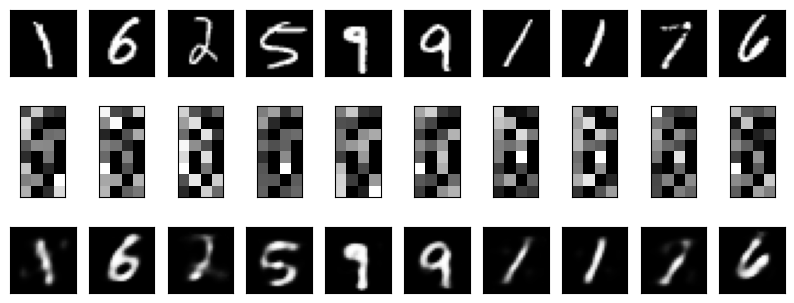

In [48]:
fig, axes = plt.subplots(nrows = 3, ncols = numero_imagens, figsize = (10, 4))
for imagens, ax_row in zip([imagens_teste, imagens_codificadas, imagens_decodificadas], axes):
  for img, ax in zip(imagens, ax_row):
    ax.imshow(img, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)